# Explore here

Paso 1: Carga del conjunto de datos

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

In [3]:

total_data = pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/alternative-time-series-project/main/sales.csv")
total_data.head()

,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633


Paso 2: Construye y analiza la serie temporal

In [4]:
from datetime import datetime, date 

total_data['date'] = pd.to_datetime(total_data['date'])

total_data = total_data.set_index('date')
new_data = total_data['sales']
new_data.head(5)

date
2022-09-03 17:10:08.079328    55.292157
2022-09-04 17:10:08.079328    53.803211
2022-09-05 17:10:08.079328    58.141693
2022-09-06 17:10:08.079328    64.530899
2022-09-07 17:10:08.079328    66.013633
Name: sales, dtype: float64

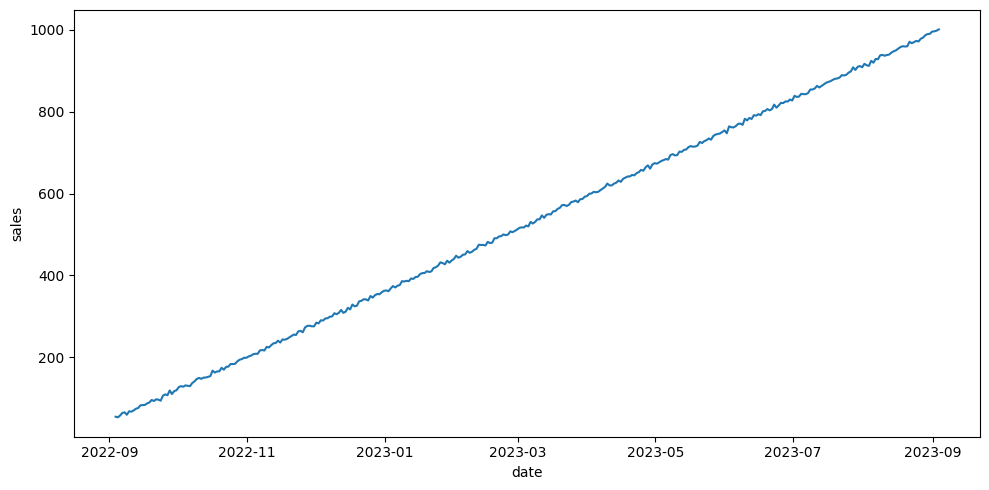

In [5]:
fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = new_data)


plt.tight_layout()

plt.show()

Tendencia: Se aprecia una tendencia ascendente, lo que indica que el número de ventas ha aumentado a lo largo del tiempo

Análisis de la estacionalidad

Para evaluar la estacionalidad de la serie temporal podemos aplicar la llamada Prueba de Dickey-Fuller (Dickey-Fuller test), que es un contraste de hipótesis en el que la hipótesis nula es que la serie es estacionaria, y la alternativa, que es no estacionaria

In [6]:
def test_stationarity(timeseries):
    print("Resultados de la prueba de Dickey-Fuller:")
    dftest = adfuller(timeseries, autolag = "AIC")
    dfoutput = pd.Series(dftest[0:4], index = ["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key,value in dftest[4].items():
        dfoutput["Critical Value (%s)"%key] = value
    return dfoutput


test_stationarity(new_data)

Resultados de la prueba de Dickey-Fuller:


Test Statistic                   0.545414
p-value                          0.986190
#Lags Used                      13.000000
Number of Observations Used    352.000000
Critical Value (1%)             -3.449065
Critical Value (5%)             -2.869786
Critical Value (10%)            -2.571163
dtype: float64

No apreciamos estacionalidad

In [7]:
decomposition = seasonal_decompose(new_data)
decomposition

Análisis de la variabilidad

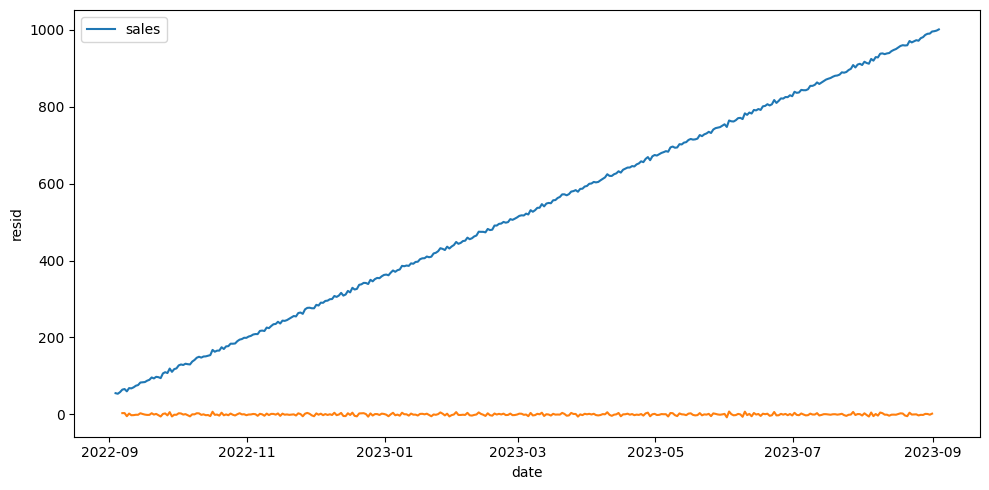

In [8]:
residual = decomposition.resid

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = total_data)
sns.lineplot(data = residual)

plt.tight_layout()

plt.show()

Análisis de la autocorrelación

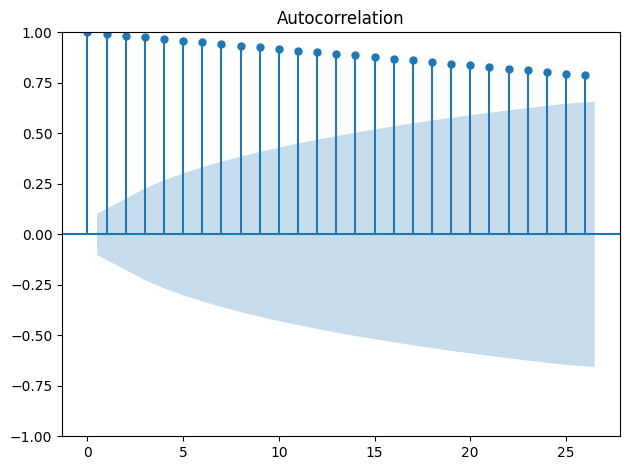

In [9]:
plot_acf(total_data)

plt.tight_layout()

plt.show()

Se aprecia una alta correlación entre los puntos y sus copias retrasadas

Entrenamiento del modelo

In [10]:
td_stationary = total_data.diff().dropna()

test_stationarity(td_stationary)

Resultados de la prueba de Dickey-Fuller:


Test Statistic                -9.430263e+00
p-value                        5.212954e-16
#Lags Used                     1.200000e+01
Number of Observations Used    3.520000e+02
Critical Value (1%)           -3.449065e+00
Critical Value (5%)           -2.869786e+00
Critical Value (10%)          -2.571163e+00
dtype: float64

Paso 3: Entrena un ARIMA

In [11]:
from pmdarima import auto_arima
model = auto_arima(td_stationary, seasonal = True, trace = True, m = 12)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=1847.118, Time=1.14 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=2096.542, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=1972.854, Time=0.17 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.87 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=2209.657, Time=0.01 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=1845.127, Time=0.79 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=1843.049, Time=0.41 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=1845.092, Time=0.90 sec
 ARIMA(1,0,2)(0,0,0)[12] intercept   : AIC=1843.587, Time=0.13 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=1841.533, Time=0.28 sec
 ARIMA(2,0,1)(1,0,0)[12] intercept   : AIC=1843.436, Time=0.88 sec
 ARIMA(2,0,1)(0,0,1)[12] intercept   : AIC=1843.433, Time=0.88 sec
 ARIMA(2,0,1)(1,0,1)[12] intercept   : AIC=inf, Time=1.00 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=1839.553, Time=0.16 sec
 ARIMA(1,0,1)(1,0,0)[12] inte

In [12]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  365
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -915.776
Date:                Sat, 07 Dec 2024   AIC                           1839.553
Time:                        09:37:48   BIC                           1855.152
Sample:                    09-04-2022   HQIC                          1845.752
                         - 09-03-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.8110      0.134     21.055      0.000       2.549       3.073
ar.L1         -0.0821      0.052     -1.592      0.111      -0.183       0.019
ma.L1         -0.9413      0.020    -47.701      0.000      -0.980      -0.903
sigma2         8.7903      0.688     12.777      0.000       7.442      10.139
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.76
Prob(Q):                              1.00   Prob(JB):                         0.68
Heteroskedasticity (H):               0.90   Skew:                             0.07
Prob(H) (two-sided):                  0.58   Kurtosis:                         2.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Paso 4: Predice con el conjunto de test

In [13]:
forecast = model.predict(10)
forecast

2023-09-04 17:10:08.079328    1.675366
2023-09-05 17:10:08.079328    2.673520
2023-09-06 17:10:08.079328    2.591621
2023-09-07 17:10:08.079328    2.598341
2023-09-08 17:10:08.079328    2.597789
2023-09-09 17:10:08.079328    2.597834
2023-09-10 17:10:08.079328    2.597831
2023-09-11 17:10:08.079328    2.597831
2023-09-12 17:10:08.079328    2.597831
2023-09-13 17:10:08.079328    2.597831
Freq: D, dtype: float64

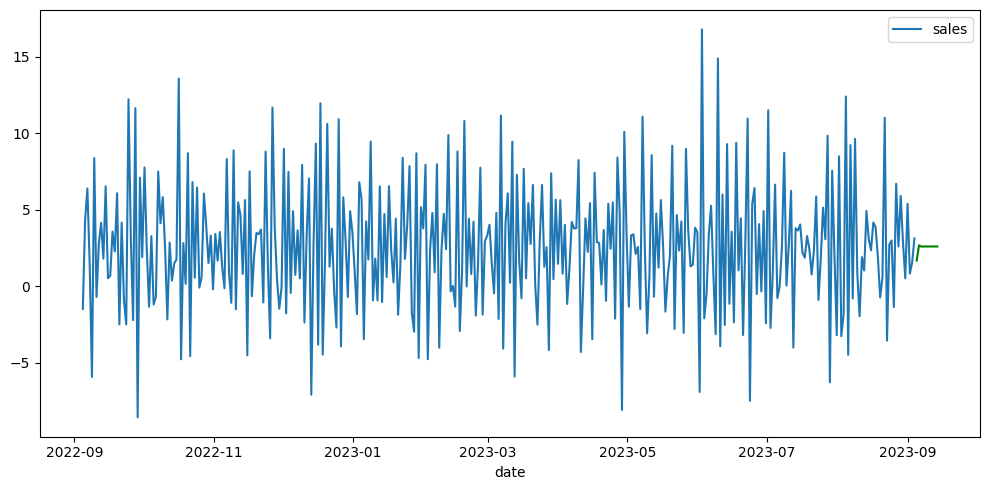

In [14]:
fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = td_stationary)
sns.lineplot(data = forecast, c = "green")

plt.tight_layout()

plt.show()

¿Cuál es el tensor de la serie temporal?

La unidad mínima de tiempo es de 24h

¿Cuál es la tendencia?

Tendencia de ventas a la alza a lo largo del tiempo

¿Es estacionaria?

No se aprecia estacionalidad

¿Existe variabilidad o presencia de ruido?

No se aprecia variablidad significativa

Paso 5: Guarda el modelo

In [16]:
from pickle import dump

dump(model, open("Arima_model.sav", "wb"))